In [ ]:
import os
import pandas as pd
import numpy as np
from typing import Union, List, Literal, Dict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from Helper_Util import *

In [ ]:
Filepath = '/content/drive/MyDrive/DSN and Microsoft Skills for Job'
pd.set_option('display.max_colwidth',200)

In [ ]:
def Load_Data(file_path: str) -> List[pd.DataFrame]:
  train = pd.read_csv(file_path+'/Housing_dataset_train.csv')
  test = pd.read_csv(file_path+'/Housing_dataset_test.csv')
  sub = pd.read_csv(file_path+'/Sample_submission.csv')

  return train, test, sub


In [ ]:
Train, Test, Sub = Load_Data(Filepath)

###Data Exploration

In [ ]:
Train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [ ]:
Test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


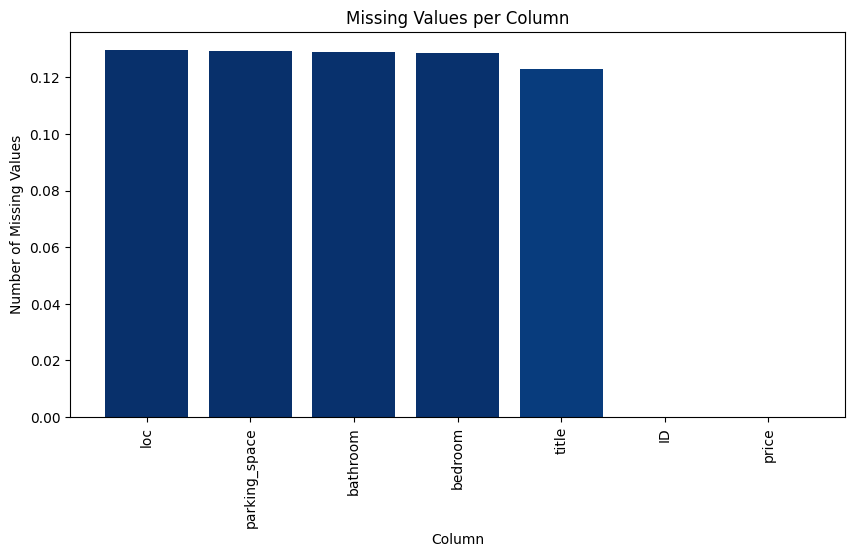

In [ ]:
missing_values = Train.isna().sum()/ Train.shape[0]
missing_values = missing_values.sort_values(ascending=False)


# Normalize the data to be between 0 and 1
norm = plt.Normalize(missing_values.values.min(), missing_values.values.max())
# Create a colormap
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
# Generate colors for each bar
colors = [cmap.to_rgba(val) for val in missing_values.values]

# Create bar plot of missing values
plt.figure(figsize=(10,5))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Column')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.show()



The missing values doesn't seem to affect the Distribution of the Price Column

<Axes: xlabel='price', ylabel='Count'>

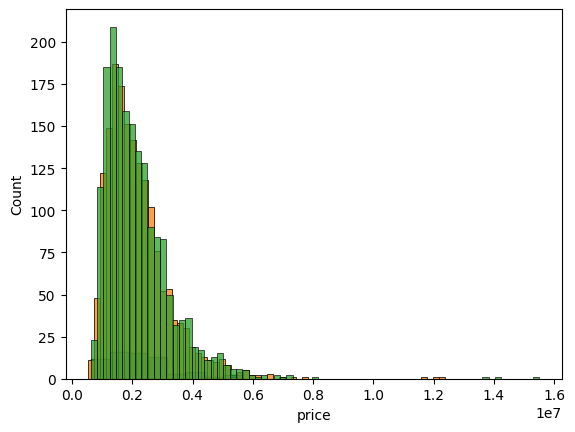

In [ ]:
sns.histplot(Train[(Train['loc'].isnull()) & (Train['title'].isnull())]['price'])
sns.histplot(Train[Train['title'].isnull()]['price'])
sns.histplot(Train[Train['loc'].isnull()]['price'])

<Axes: xlabel='price', ylabel='Count'>

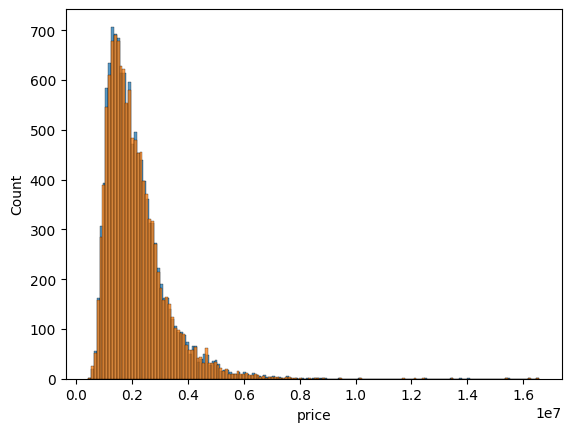

In [ ]:
sns.histplot(Train[~Train['title'].isnull()]['price'])
sns.histplot(Train[~Train['loc'].isnull()]['price'])

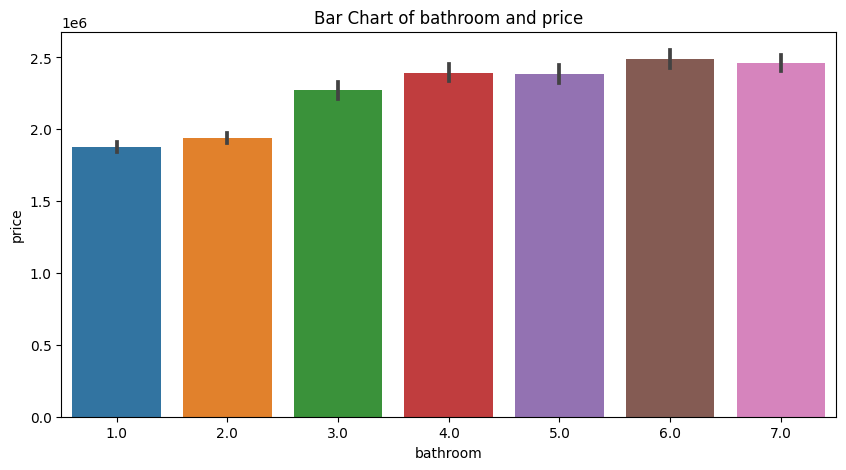

In [ ]:
barchart(Train['bathroom'],Train['price'])

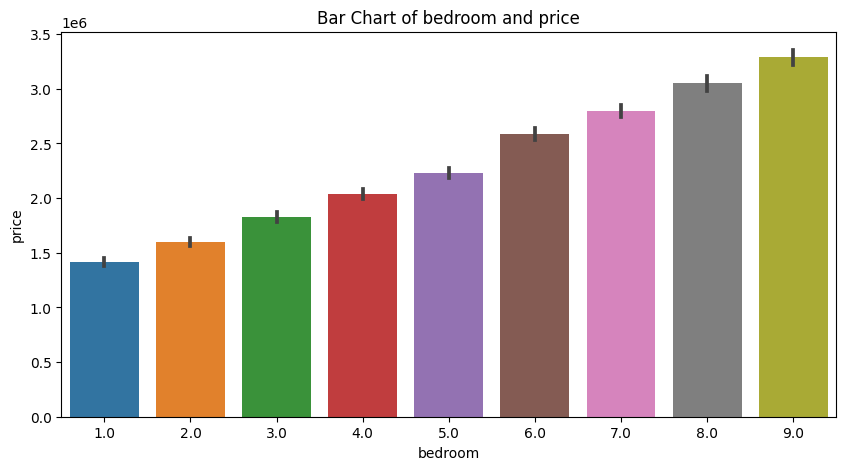

In [ ]:
barchart(Train['bedroom'],Train['price'])

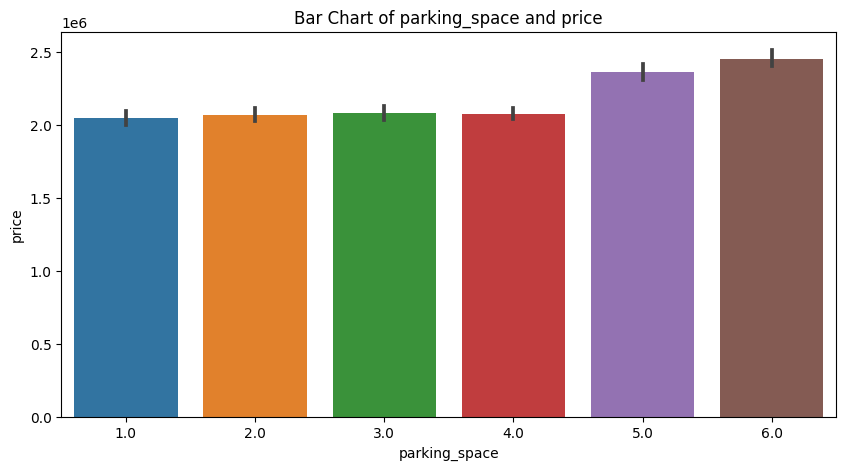

In [ ]:
barchart(Train['parking_space'],Train['price'])

###Baseline_Score

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, Dataset, early_stopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from abc import ABC, abstractmethod
import random

In [ ]:
!pip install catboost -q
from catboost import CatBoostRegressor, Pool

In [ ]:
class Baseline_score():

  """
    A class to calculate baseline scores for regression tasks.

    Args:
        train: A pandas DataFrame containing the training data.
        model: A regression model.
        scaler: A scaler object, or None.
        split_method: The method to use for splitting the data, either "train_test_split" or "KFold".
        return_baseline: Whether to return the baseline scores, or just the final score.
        num_split: The number of splits to use for KFold cross-validation.
        random_seed: The random seed to use for splitting the data.
        VERBOSE: The verbosity level.

    """

  def __init__(
      self,
      train: pd.DataFrame,
      model: Union[XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor],
      scaler: Union[StandardScaler, MinMaxScaler, None] = None,
      split_method: Literal["KFold", "train_test_split"] = "KFold",
      return_baseline: Literal[True, False] = True,
      num_split = 5,
      random_seed = 42,
      VERBOSE: int = 0
  ):

    # Check that the model is a valid regression model.
    if not isinstance(model, (XGBRegressor, LGBMRegressor, CatBoostRegressor,RandomForestRegressor)):
      raise TypeError("model must be a class of either XGBRegressor, LGBMRegressor, CatBoostRegressor, or LinearRegression")

    # Check that the scaler is a valid scaler object, or None.
    if scaler is not None and not isinstance(scaler, (StandardScaler, MinMaxScaler)):
        raise TypeError("scaler must be a class of either StandardScaler, MinMaxScaler or None")

    # Check that the train data is a pandas DataFrame.
    if not isinstance(train, pd.DataFrame):
      raise TypeError("train must be a DataFrame")

    # Set class attributes
    self.train = train
    self.model = model
    self.scaler = scaler
    self.split = split_method
    self.num_split = num_split
    self.seed = random_seed
    self.return_baseline = return_baseline
    self.VERBOSE = VERBOSE
    self.feature_importances = None
    self.bsv = {}
    random.seed(random_seed)
    np.random.seed(random_seed)

  def run(self)-> float:
    X = self.train.iloc[:,:-1]
    self.feature_importances = np.zeros(X.shape[1])
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.seed)

      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

      if isinstance(self.model, LGBMRegressor):
        self.model.fit(X_train, y_train, eval_set=(X_test, y_test), callbacks=[early_stopping(stopping_rounds=100)])

      elif isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

      elif isinstance(self.model, XGBRegressor):
        self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

      else:
        self.model.fit(X_train,y_train)

      self.feature_importances += self.model.feature_importances_
      if isinstance(self.model, XGBRegressor):
        results = self.model.evals_result()
        evals_result = self.model.evals_result()
        best_scores = {}
        for metric in self.model.eval_metric:
          best_scores[metric] = min(evals_result['validation_0'][metric])
        for metric, score in best_scores.items():
          print(f"Best {metric}: {score}")
      else:
        results = self.model.best_score_
      preds = self.model.predict(X_test)
      train_baseline = self.model.predict(X)
      self.bsv.update({'train':train_baseline})

      if self.VERBOSE > 0:
        print(f"split: {(self.split).upper()}")
        print(f"MAE {mean_absolute_error(y_test, preds)}")
        print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
        print(f"Model RMSE: {results.values()}")

      score = mean_squared_error(y_test,preds,squared=False)

      if self.return_baseline:
        return score, self.bsv

      return score

    else:
      fold = KFold(n_splits=self.num_split)
      oof_f1 = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]

        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

        if isinstance(self.model, LGBMRegressor):
          self.model.fit(X_train, y_train, eval_set=(X_test, y_test),callbacks=[early_stopping(stopping_rounds=20)])

        elif isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

        elif isinstance(self.model, XGBRegressor):
          self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

        else:
          self.model.fit(X_train,y_train)

        self.feature_importances += self.model.feature_importances_
        if isinstance(self.model, XGBRegressor):
          results = self.model.evals_result()
          evals_result = self.model.evals_result()
          best_scores = {}
          for metric in self.model.eval_metric:
            best_scores[metric] = min(evals_result['validation_0'][metric])
          for metric, score in best_scores.items():
            print(f"Best {metric}: {score}")
        else:
          results = self.model.best_score_
        preds=self.model.predict(X_test)
        train_baseline = self.model.predict(X)
        self.bsv.update({f'{self.split}{i}train':train_baseline})

        if self.VERBOSE > 0:
          print(f"split {self.split}{i}")
          print(f"MAE {mean_absolute_error(y_test, preds)}")
          print(f"RMSE {mean_squared_error(y_test,preds,squared=False)}")
          print(f"Model RMSE: {results.values()}")
        oof_f1.append(mean_squared_error(y_test,preds,squared=False))
        i += 1

      self.feature_importances = self.feature_importances / self.num_split
      score = sum(oof_f1)/self.num_split

      if self.return_baseline:
        return score, self.bsv

      return score

  def plot_features(self, n_features=20):
    X = self.train.iloc[:,:-1]
    features = pd.DataFrame({'feature': list(X.columns),
                             'importance': self.feature_importances}).sort_values('importance', ascending = True)
    norm = plt.Normalize(features['importance'][:n_features].min(), features['importance'][:n_features].max())
    cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
    colors = [cmap.to_rgba(val) for val in features['importance'][:n_features].values]
    plt.figure(figsize=(25,10))
    plt.barh(features['feature'][:n_features],features['importance'][:n_features], color=colors)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()




In [ ]:
class Baseline_predict(Baseline_score):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.preds = None

  def predict(self, test):
    X = self.train.iloc[:,:-1]
    y = self.train.iloc[:,-1]

    if self.split == "train_test_split":
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.seed)
      if self.scaler != None:
        X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

      if isinstance(self.model, LGBMRegressor):
        self.model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)], verbose=self.VERBOSE)

      elif isinstance(self.model, CatBoostRegressor):
        self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

      elif isinstance(self.model, XGBRegressor):
        self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

      else:
        self.model.fit(X_train,y_train)

      train_baseline = self.model.predict(test[X.columns])
      self.bsv.update({'train':train_baseline})
      self.preds = self.model.predict(test[X.columns])
      print(f"split: {(self.split).upper()}")

      if self.return_baseline:
        return self.preds, self.bsv

      return self.preds

    else:
      fold = KFold(n_splits=self.num_split)
      oof_preds = []
      i = 1
      for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        if self.scaler != None:
          X_train, X_test = self.scaler.fit_transform(X_train), self.scaler.fit_transform(X_test)

        if isinstance(self.model, LGBMRegressor):
          self.model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)], verbose=self.VERBOSE)

        elif isinstance(self.model, CatBoostRegressor):
          self.model.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,early_stopping_rounds=20,verbose=self.VERBOSE)

        elif isinstance(self.model, XGBRegressor):
         self.model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=20,verbose=self.VERBOSE)

        else:
          self.model.fit(X_train,y_train)

        pred=self.model.predict(test[X.columns])
        train_baseline = self.model.predict(test[X.columns])
        self.bsv.update({f'{self.split}{i}train':train_baseline})
        if self.VERBOSE > 0:
          print(f"split {self.split}{i}")
        oof_preds.append(pred)
        i += 1

      self.preds = oof_preds

      if self.return_baseline:
        return self.preds, self.bsv

      return self.preds

  def submission(self, test):
    pres = self.preds
    if self.split == 'KFold':
      final_preds = sum(pres)/self.num_split
    else:
      final_preds = pres
    predictions_df = pd.DataFrame({'id': test.id, 'target': final_preds})
    return predictions_df




In [ ]:
TT = Train.drop(['ID'],axis=1)
tests = Test.drop(['ID'], axis=1)

ohe = OneHotEncoder()
cat_features = ['loc','title']
oe = OrdinalEncoder()
for col in cat_features:
  tests[col] = oe.fit_transform(tests[[col]])
  TT[col] = oe.fit_transform(TT[[col]])

tests.fillna(0, inplace=True)
TT.fillna(0, inplace=True)

In [ ]:
cbc = CatBoostRegressor(loss_function='RMSE',custom_metric=['RMSE','MAE','Huber:delta=0.5'],learning_rate=0.043)
lgb = LGBMRegressor(objective='rmse',metric=['l1', 'l2', 'huber'],learning_rate=0.08,max_depth=9,n_estimators=5000)
xgb = XGBRegressor(objective='reg:squarederror',eval_metric=['mae', 'rmse', 'mape'])

In [ ]:
Baseline = Baseline_score(train=TT,model=cbc,split_method='KFold',num_split=20,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

CV_RMSE_Score:548898.1814255447


In [ ]:
Baseline = Baseline_score(train=TT,model=lgb,split_method='KFold',num_split=20,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

In [ ]:
Baseline = Baseline_score(train=TT,model=xgb,split_method='KFold',num_split=20,return_baseline=True,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

In [ ]:
Predictions = Baseline_predict(train=TT,model=cbc,split_method='KFold',return_baseline=True,VERBOSE=0,random_seed=0)
predict,bsv_test = Predictions.predict(tests)


In [ ]:
predictions_df = pd.DataFrame({'ID': Test.ID, 'price': sum(predict)/5})
predictions_df.to_csv('DSN_1st_sub.csv',index=False)

##Feature Engineering

In [ ]:
Train['target'] = 'Train'
Test['target'] = 'Test'

data = pd.concat([Train, Test],axis=0).reset_index(drop=True)

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
ohe_mod = ohe.fit(data[['loc','title','bathroom','bedroom','parking_space']])
ohe_cols = ohe_mod.get_feature_names_out()
ohe_data = ohe.transform(data[['loc','title','bathroom','bedroom','parking_space']])

In [ ]:
ohe_data = pd.DataFrame(ohe_data, columns=ohe_cols)
ohe_concat = pd.concat([data, ohe_data],axis=1)

In [ ]:
ohe_concat.head()

,ID,loc,title,bedroom,bathroom,parking_space,price,target,loc_Abia,loc_Adamawa,...,bedroom_8.0,bedroom_9.0,bedroom_nan,parking_space_1.0,parking_space_2.0,parking_space_3.0,parking_space_4.0,parking_space_5.0,parking_space_6.0,parking_space_nan
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,Train,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689,Train,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814,Train,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,Train,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898,Train,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
title_columns = ohe_concat.filter(like="title_").columns
bathroom_columns = ohe_concat.filter(like="bathroom_").columns
bedroom_columns = ohe_concat.filter(like="bedroom_").columns
parking_space_columns = ohe_concat.filter(like="parking_space_").columns
loc_columns = ohe_concat.filter(like="loc_").columns

In [ ]:
loc_title_sum = ohe_concat.groupby(['loc'])[title_columns].transform('sum')
loc_bedroom_sum = ohe_concat.groupby(['loc'])[bedroom_columns].transform('sum')
loc_bathroom_sum = ohe_concat.groupby(['loc'])[bathroom_columns].transform('sum')
loc_parking_space_sum = ohe_concat.groupby(['loc'])[parking_space_columns].transform('sum')

In [ ]:
loc_bedroom = ohe_concat.groupby(['loc'])[['bedroom']].sum().sort_values(by=['bedroom'],ascending=False)
loc_bedroom_map = {key: value for key, value in zip(loc_bedroom.index, range(len(loc_bedroom.index)))}

loc_bathroom = ohe_concat.groupby(['loc'])[['bathroom']].sum().sort_values(by=['bathroom'],ascending=False)
loc_bathroom_map = {key: value for key, value in zip(loc_bathroom.index, range(len(loc_bathroom.index)))}

loc_parking_space = ohe_concat.groupby(['loc'])[['parking_space']].sum().sort_values(by=['parking_space'],ascending=False)
loc_parking_space_map = {key: value for key, value in zip(loc_parking_space.index, range(len(loc_parking_space.index)))}

In [ ]:
ohe_concat['map_loc_bedroom'] = ohe_concat['loc'].map(loc_bedroom_map)
ohe_concat['map_loc_bathroom'] = ohe_concat['loc'].map(loc_bathroom_map)
ohe_concat['map_loc_parking_space'] = ohe_concat['loc'].map(loc_parking_space_map)

In [ ]:
# ohe_concat['map_loc_mean_weighted'] = ohe_concat[['map_loc_bedroom', 'map_loc_bathroom', 'map_loc_parking_space']].mean(axis=1)
ohe_concat['map_loc_sum_weighted'] = ohe_concat[['map_loc_bedroom', 'map_loc_bathroom', 'map_loc_parking_space']].sum(axis=1)

In [ ]:
loc_values = {key: value for key, value in zip(ohe_concat['loc'].values, ohe_concat['map_loc_sum_weighted'].values)}
for col in loc_columns:
  location = col.split("_")[1]
  if location in loc_values.keys():
    ohe_concat[col] = np.where(ohe_concat[col]==1,loc_values[location],0)

In [ ]:
ohe_concat['N_loc_weighted'] = np.log1p(ohe_concat['map_loc_bedroom'] * ohe_concat['map_loc_bathroom'] * ohe_concat['map_loc_parking_space'])

In [ ]:
title_loc_sum = ohe_concat.groupby(['title'])[loc_columns].transform('sum')
title_bedroom_sum = ohe_concat.groupby(['title'])[bedroom_columns].transform('sum')
title_bathroom_sum = ohe_concat.groupby(['title'])[bathroom_columns].transform('sum')
title_parking_space_sum = ohe_concat.groupby(['title'])[parking_space_columns].transform('sum')

In [ ]:
title_bedroom = ohe_concat.groupby(['title'])[['bedroom']].sum().sort_values(by=['bedroom'],ascending=False)
title_bedroom_map = {key: value for key, value in zip(title_bedroom.index, range(len(title_bedroom.index)))}

title_bathroom = ohe_concat.groupby(['title'])[['bathroom']].sum().sort_values(by=['bathroom'],ascending=False)
title_bathroom_map = {key: value for key, value in zip(title_bathroom.index, range(len(title_bathroom.index)))}

title_parking_space = ohe_concat.groupby(['title'])[['parking_space']].sum().sort_values(by=['parking_space'],ascending=False)
title_parking_space_map = {key: value for key, value in zip(title_parking_space.index, range(len(title_parking_space.index)))}

In [ ]:
ohe_concat['map_title_bedroom'] = ohe_concat['title'].map(title_bedroom_map)
ohe_concat['map_title_bathroom'] = ohe_concat['title'].map(title_bathroom_map)
ohe_concat['map_title_parking_space'] = ohe_concat['title'].map(title_parking_space_map)

In [ ]:
# ohe_concat['map_title_mean_weighted'] = ohe_concat[['map_title_bedroom', 'map_title_bathroom', 'map_title_parking_space']].mean(axis=1)
ohe_concat['map_title_sum_weighted'] = ohe_concat[['map_title_bedroom', 'map_title_bathroom', 'map_title_parking_space']].sum(axis=1)

In [ ]:
title_values = {key: value for key, value in zip(ohe_concat['title'].values, ohe_concat['map_title_sum_weighted'].values)}
for col in title_columns:
  titles = col.split("_")[1]
  if titles in loc_values.keys():
    ohe_concat[col] = np.where(ohe_concat[col]==1,loc_values[titles],0)

In [ ]:
ohe_concat['N_title_weighted'] = np.log1p(ohe_concat['map_title_bedroom'] * ohe_concat['map_title_bathroom'] * ohe_concat['map_title_parking_space'])

In [ ]:
ohe_concat['N_Unweighted'] = ohe_concat['map_loc_sum_weighted']//3 * ohe_concat['map_title_sum_weighted'] //3 * ohe_concat['bedroom'] * ohe_concat['bathroom'] * ohe_concat['parking_space']

In [ ]:
ohe_concat = ohe_concat.join(loc_title_sum, rsuffix="_loc_sum")
ohe_concat = ohe_concat.join(loc_bedroom_sum, rsuffix="_loc_sum")
ohe_concat = ohe_concat.join(loc_bathroom_sum, rsuffix="_loc_sum")
ohe_concat = ohe_concat.join(loc_parking_space_sum, rsuffix="_loc_sum")
ohe_concat = ohe_concat.join(title_bedroom_sum, rsuffix="_title_sum")
ohe_concat = ohe_concat.join(title_bathroom_sum, rsuffix="_title_sum")
ohe_concat = ohe_concat.join(title_parking_space_sum, rsuffix="_title_sum")

In [ ]:
ohe_concat['loc/title'] = data['loc'] + "_" + ohe_concat['title']
ohe_concat['loc/title_bedroom_mean'] = ohe_concat.groupby(['loc/title'])[['bedroom']].transform('mean')
ohe_concat['loc/title_bathroom_mean'] = ohe_concat.groupby(['loc/title'])[['bathroom']].transform('mean')
ohe_concat['loc/title_parking_space_mean'] = ohe_concat.groupby(['loc/title'])[['parking_space']].transform('mean')

In [ ]:
ohe_concat['bedroom_check'] = np.where(ohe_concat['bedroom']<3,1,2)
ohe_concat['bathroom_check'] = np.where(ohe_concat['bathroom']<3,1,2)
ohe_concat['parking_space_check'] = np.where(ohe_concat['parking_space']<3,1,2)

In [ ]:
ohe_concat['sum_weighted'] = ohe_concat[['map_loc_sum_weighted','map_title_sum_weighted','bedroom_check','bathroom_check','parking_space_check']].sum(axis=1)
ohe_concat['mean_weighted'] = ohe_concat[['map_loc_sum_weighted','map_title_sum_weighted','bedroom_check','bathroom_check','parking_space_check']].mean(axis=1)

In [ ]:
ohe_concat['N_log_weighted'] = ohe_concat['N_loc_weighted'] * ohe_concat['N_title_weighted'] * ohe_concat['bedroom_check'] * ohe_concat['bathroom_check'] * ohe_concat['parking_space_check']

In [ ]:
ohe_concat['N_weighted'] = np.log(ohe_concat['sum_weighted'] * ohe_concat['mean_weighted'])

In [ ]:
from sklearn.cluster import KMeans
def kmeans_clustering(df: pd.DataFrame, n_clusters: int) -> List:
  df = df.copy()
  df.fillna(0, inplace=True)
  kmeans = KMeans(n_clusters=n_clusters)
  kmeans.fit(df)
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_
  return labels, centroids

h1_labels, h1_centroids = kmeans_clustering(ohe_concat[['map_loc_sum_weighted','map_title_sum_weighted','bedroom','bathroom','parking_space']],n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
train = ohe_concat[ohe_concat['target'] == "Train"]
test = ohe_concat[ohe_concat['target'] == "Test"]

In [ ]:
bedroom_target = train.groupby(['bedroom'])[['price']].mean().to_dict()['price']
title_target = train.groupby(['title'])[['price']].mean().to_dict()['price']
loc_target = train.groupby(['loc'])[['price']].mean().to_dict()['price']

In [ ]:
train['bedroom'] = train['bedroom'].map(bedroom_target)
test['bedroom'] = test['bedroom'].map(bedroom_target)

train['loc'] = train['loc'].map(loc_target)
test['loc'] = test['loc'].map(loc_target)

train['title'] = train['title'].map(title_target)
test['title'] = test['title'].map(title_target)

<ipython-input-658-5372f8153b7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bedroom'] = train['bedroom'].map(bedroom_target)
<ipython-input-658-5372f8153b7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bedroom'] = test['bedroom'].map(bedroom_target)
<ipython-input-658-5372f8153b7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [ ]:
train['bedroom'] = np.log(train['bedroom'])
test['bedroom'] = np.log(test['bedroom'])

train['loc'] = np.log(train['loc'])
test['loc'] = np.log(test['loc'])

train['title'] = np.log(train['title'])
test['title'] = np.log(test['title'])

<ipython-input-659-f9b412007ce7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bedroom'] = np.log(train['bedroom'])
<ipython-input-659-f9b412007ce7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bedroom'] = np.log(test['bedroom'])
<ipython-input-659-f9b412007ce7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

## Modelling

In [ ]:
train = train.drop(['target','ID'],axis=1)
test = test.drop(['target','ID'],axis=1)

In [ ]:
TT = train[[col for col in train.columns if col != 'price'] + ['price']]

In [ ]:
cat_features = ['loc/title']
oe = OrdinalEncoder()
for col in cat_features:
  test[col] = oe.fit_transform(test[[col]])
  TT[col] = oe.fit_transform(TT[[col]])

# test.fillna(0, inplace=True)
# TT.fillna(0, inplace=True)

In [ ]:
# TT = TT.sort_values(by=['bedroom'])

In [ ]:
XY =  TT.drop(['bedroom_1.0', 'bedroom_2.0', 'bedroom_3.0', 'bedroom_4.0',
       'bedroom_5.0', 'bedroom_6.0', 'bedroom_7.0', 'bedroom_8.0',
       'bedroom_9.0', 'bedroom_nan','parking_space_1.0', 'parking_space_2.0', 'parking_space_3.0',
       'parking_space_4.0', 'parking_space_5.0', 'parking_space_6.0',
       'parking_space_nan','title_Apartment','title_Detached duplex','title_Flat', 'title_Mansion',
       'title_Penthouse', 'title_Semi-detached duplex', 'title_Terrace duplex',
       'title_Townhouse', 'title_nan','loc/title','loc/title_bedroom_mean','loc/title_parking_space_mean','parking_space_1.0_loc_sum',
      'parking_space_2.0_loc_sum','parking_space_3.0_loc_sum', 'parking_space_4.0_loc_sum',
       'parking_space_5.0_loc_sum', 'parking_space_6.0_loc_sum',
       'parking_space_nan_loc_sum','map_title_bedroom', 'map_title_bathroom',
       'map_title_parking_space','parking_space','bathroom'],axis=1)

In [ ]:
cbc = CatBoostRegressor(loss_function='RMSE',custom_metric=['RMSE','MAE','Huber:delta=0.5'],learning_rate=0.043)
lgb = LGBMRegressor(objective='rmse',metric=['l1', 'l2', 'huber'])
xgb = XGBRegressor(objective='reg:squarederror',eval_metric=['mae', 'rmse', 'mape'])

In [ ]:
Baseline = Baseline_score(train=XY,model=cbc,split_method='KFold',num_split=5,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

CV_RMSE_Score:511678.46468210994


CatBoost CV_RMSE_Score:514183.1002880767       

336668.7144

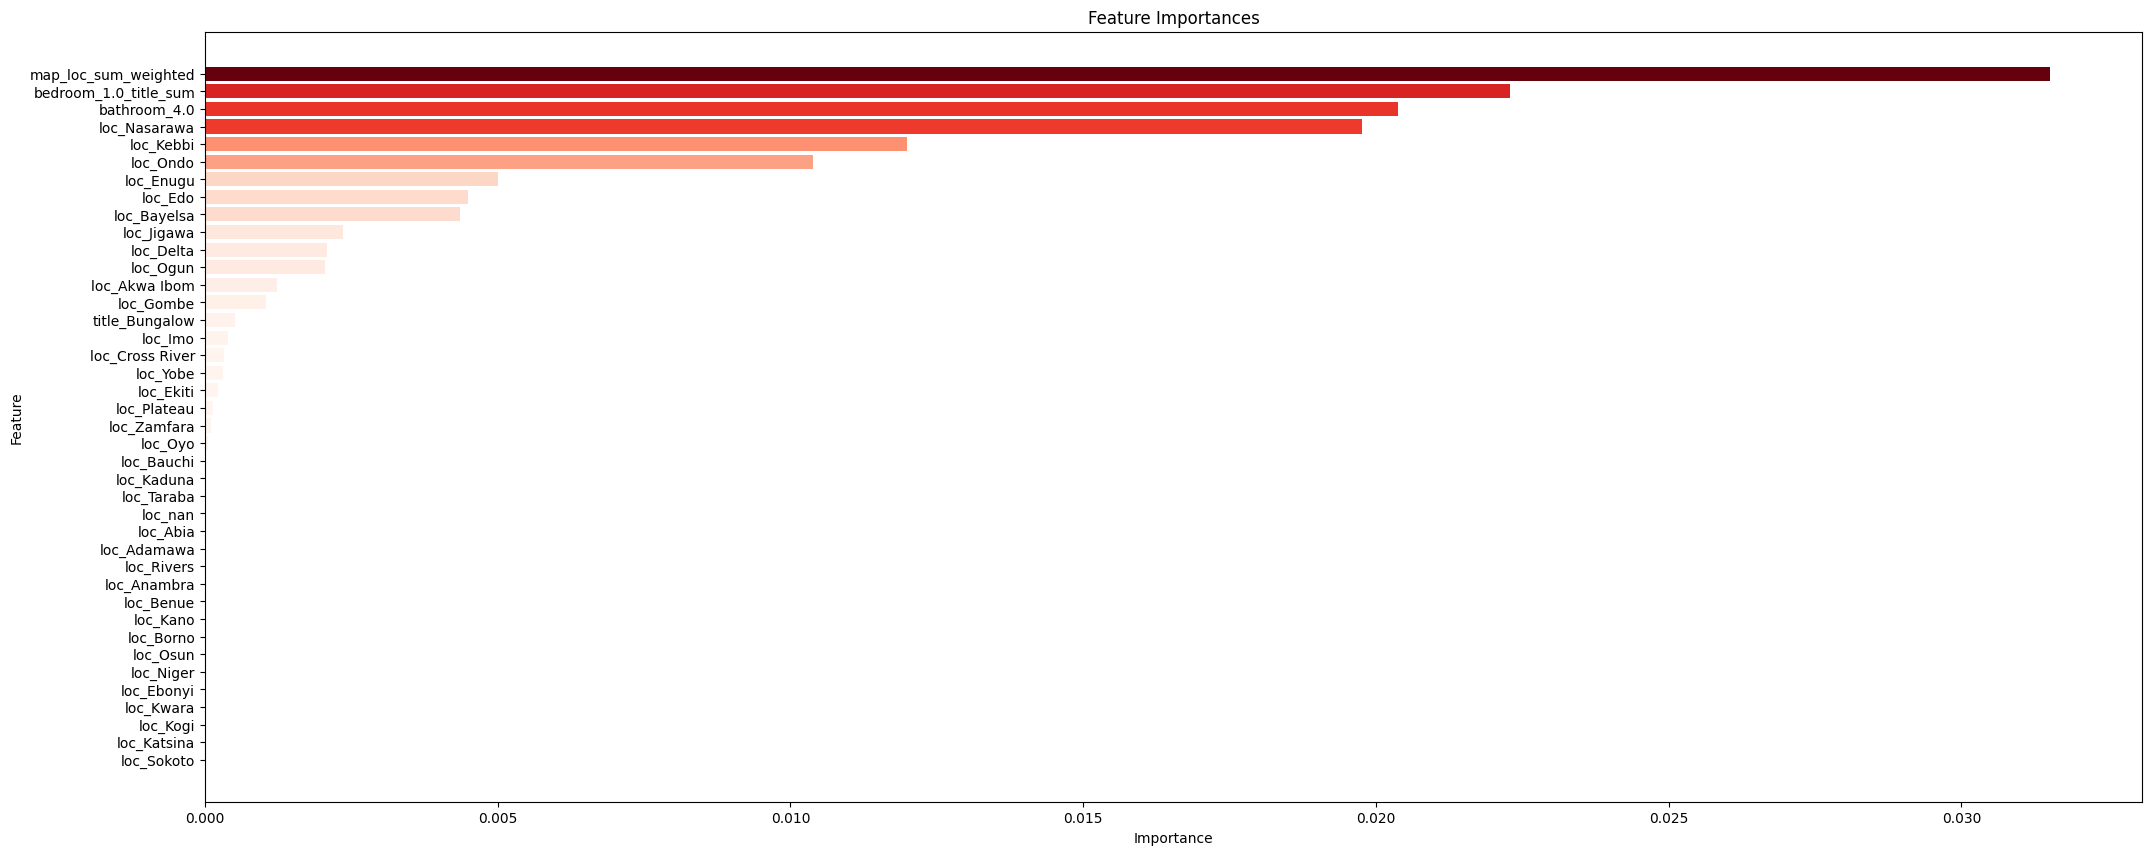

In [ ]:
Baseline.plot_features(n_features=40)

In [ ]:
Baseline_ohe = Baseline_predict(train=TT,model=cbc,split_method='KFold',num_split=5,return_baseline=True,VERBOSE=0,random_seed=0)
predict0,bsv_test0 = Baseline_ohe.predict(test)

In [ ]:
predictions_df = pd.DataFrame({'ID': Test.ID, 'price': predict0/5})
predictions_df.to_csv('DSN_60th_sub.csv',index=False)

In [ ]:
predictions_df

,ID,price
0,845,2.315671e+06
1,1924,1.000631e+06
2,10718,1.238846e+06
3,12076,7.840275e+06
4,12254,1.845992e+06
...,...,...
5995,1594,1.698362e+06
5996,2416,1.920386e+06
5997,10195,2.006389e+06
5998,9455,1.377605e+06


In [ ]:
Baseline = Baseline_score(train=XY,model=lgb,split_method='KFold',num_split=5,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score 0 :{lgb_score}")

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 256534	valid_0's l2: 2.38864e+11	valid_0's huber: 230880
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 259780	valid_0's l2: 3.10291e+11	valid_0's huber: 233801
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 266164	valid_0's l2: 2.66164e+11	valid_0's huber: 239547
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 282788	valid_0's l2: 2.89965e+11	valid_0's huber: 254509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 268207	valid_0's l2: 3.09681e+11	valid_0's huber: 241386
CV_RMSE_Score 0 :531331.9381103695


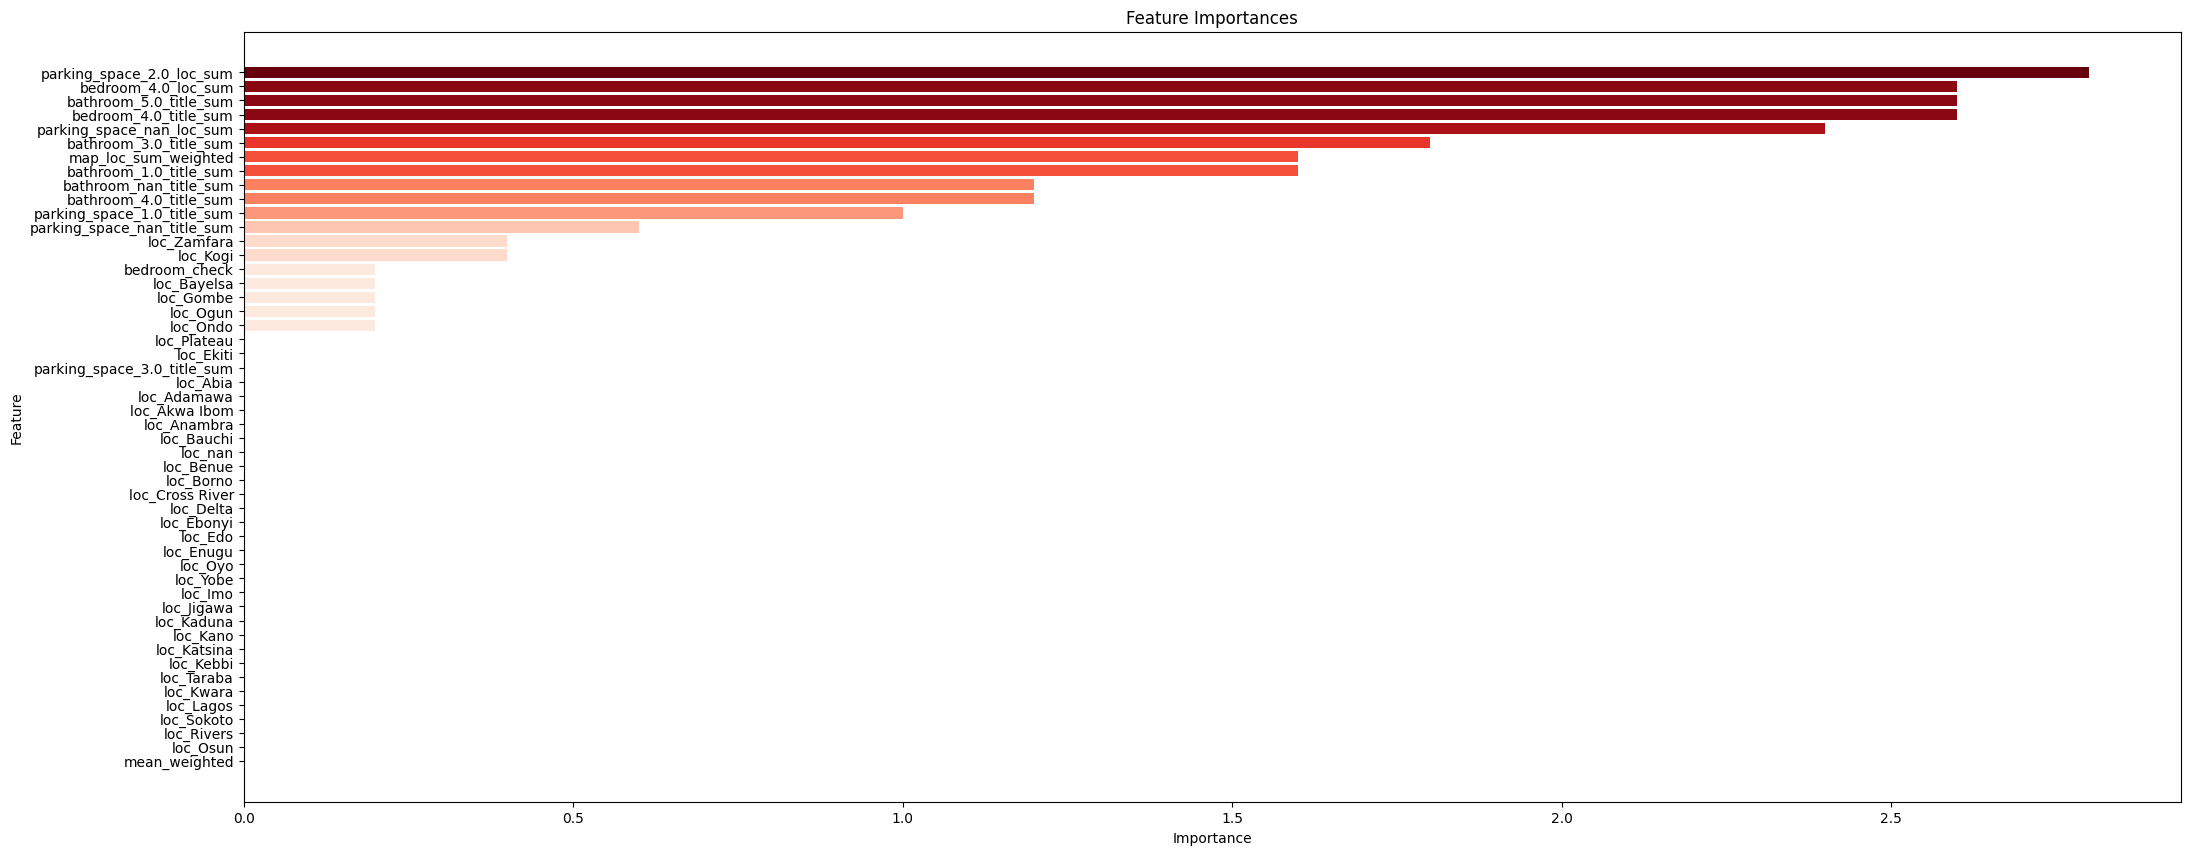

In [ ]:
Baseline.plot_features(n_features=50)

In [ ]:
Baseline = Baseline_score(train=XY,model=xgb,split_method='KFold',num_split=5,VERBOSE=0,random_seed=0)
lgb_score,bsv_1 = Baseline.run()
print(f"CV_RMSE_Score:{lgb_score}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best mae: 255135.65089285714
Best rmse: 463182.0347701836
Best mape: 0.12276560877568013


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best mae: 262822.1390290179
Best rmse: 567176.4069371622
Best mape: 0.12368024493969253


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best mae: 266395.986875
Best rmse: 501088.62642984337
Best mape: 0.13012494896209317


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best mae: 279774.28310267854
Best rmse: 546832.7748344196
Best mape: 0.12794025443694554


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best mae: 272907.8737165179
Best rmse: 538955.6259583621
Best mape: 0.12749980712734343
CV_RMSE_Score:526135.587177059


XGBOOST: CV_RMSE_Score:534851.0364106243

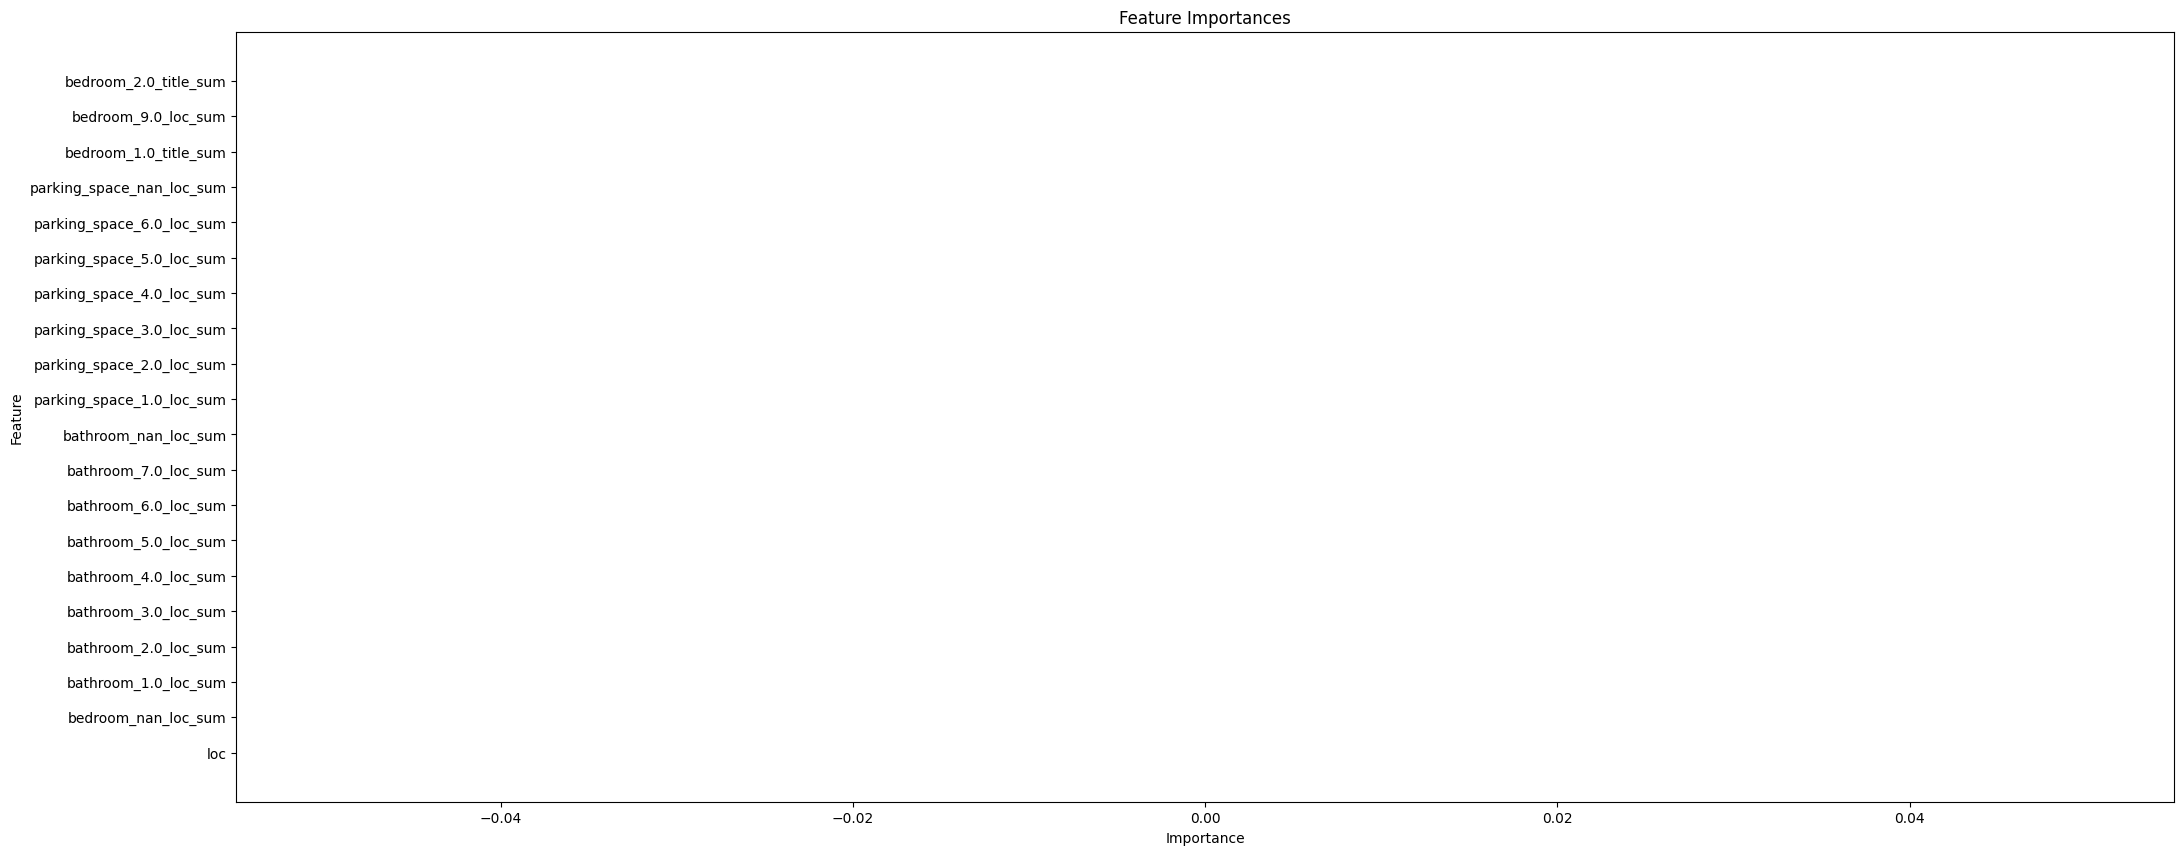

In [ ]:
Baseline.plot_features()